In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 16
epochs = 10

In [4]:
def mnist(train_part, transform=None, download=False):
    dataset = torchvision.datasets.MNIST('.', download=download, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform, download=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
dataloaders = (train_dataloader, test_dataloader)

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1,1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
        return encoded


In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.upsample1(self.relu(self.conv1(input)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, super_resolution=False):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()


In [10]:
def train(dataloaders, model, loss_fn, optimizer, epochs):
    train_dataloader, test_dataloader = dataloaders

    tqdm_iter = tqdm(range(epochs))

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for (imgs, labels) in train_dataloader:
            preds = model(imgs)
            loss = loss_fn(preds, imgs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for (imgs, labels) in test_dataloader:
                preds = model(imgs)
                loss = loss_fn(preds, imgs)
                test_loss += loss.item()
                
        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dict = {'train_loss': train_loss, 'test_loss': test_loss}
        tqdm_iter.set_postfix(tqdm_dict, refresh=True)
        tqdm_iter.refresh()


In [11]:
train(dataloaders, model, loss_fn, optimizer, epochs)

100%|██████████| 10/10 [04:56<00:00, 29.70s/it, train_loss=0.0939, test_loss=0.0928]


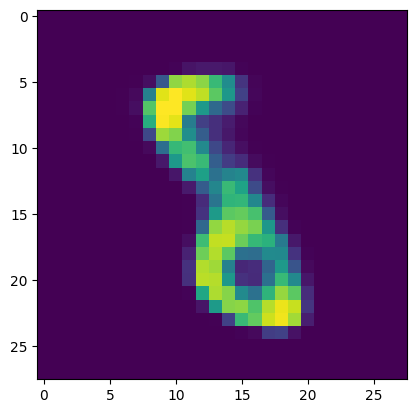

In [52]:
eights = []
for (imgs, labels) in dataloaders[0]:
    for i in range(batch_size):
        img = imgs[i]
        label = labels[i]
        if label == 8:
            eights.append(img)

eights = eights[:10]

model.eval()
with torch.no_grad():
    preds = []
    for e in eights:
        preds.append(model(e.view(1, 1, 28, 28)))

plt.imshow(preds[3][0][0])


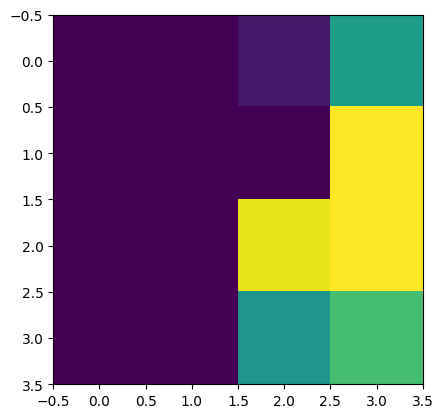

In [62]:
num = 8
out = model.encoder(eights[num].view(1, 1, 28, 28)).detach()
plt.imshow(out[0][0])

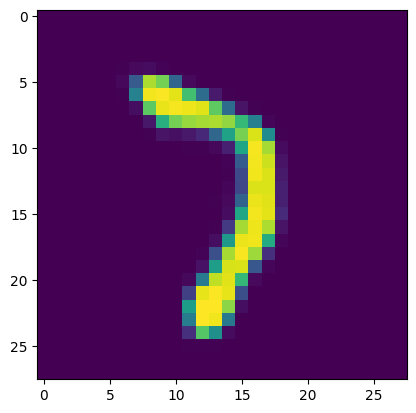

In [18]:
new_img = model.decoder(out.view(1, 8, 4, 4)).detach()
plt.imshow(new_img[0, 0])